## Variable Definifitions

In [183]:
#def init():
    #CHANGE THIS TO YOUR TRAIN FOLDER
#image_folder = '/Users/yolanda/Desktop/Training_ML' 
#image_folder = 'C:/Users/danie/Desktop/Training_ML'
image_folder = 'C:/Study/Semester2/Machine Learning/smaller2'

TOO_SMALL = 200000
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
img_height = 1888 #Usually 128. this might change depending on Annaya & Danielle's input 
img_width = 1888 #Usually 128. this might change depending on Annaya & Danielle's input 
epochs = 10 #Start with 1, and increase to 10, 100, 500, 1000 and 3000. 11 is the recommended number of runs through the training dataset. We will probably have to tune this. 
#total_training = total number of training data len()
batch_size = 1 #test different ones from 1 to 2, 5, 10, etc
total_images = 1

In [184]:
#pip install opencv-python

## Import Packages

In [185]:
import tensorflow as tf

In [186]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import cv2
import glob
import pandas as pd
import joblib

In [187]:
from tensorflow.keras import layers

In [188]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D

In [189]:
#pip show tensorflow

In [190]:
from skimage import data, io,color
from skimage.io import imread_collection #loads a collection of images
from skimage.io import imread, imshow
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

In [191]:
tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,)

In [192]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Preprocessing

## Define Sizes of Images

In [193]:
#Define sizes of images based on their resolution
#Image shape and resolution

#TODO make the IMG sizes make sense


def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size

## Create Dataframe of Images

In [194]:
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg')

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    print("processing", df_length, "photos for training")
    
    height= []
    width = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height.append(img.shape[0])
        width.append(img.shape[1])
        
    df["height"] = height
    df["width"] = width
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    
    return df

## Principal Component Analysis of Image

In [195]:
#PCA rgb then pass to prep_img as an rgb image

def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 100)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
        
    return RGB_compressed

## Image Padding

In [196]:
# image padding

def pad(image):
    
    height = image.shape[0]
    width = image.shape[1]

    WHITE = [255,255,255]
    MAX = 1888
    
    if height % 2 == 0:
        top = int((MAX - height)/ 2)
        bottom = int((MAX - height)/ 2)
    else: 
        top = int((MAX - (height-1))/ 2)
        bottom = int(((MAX - (height-1))/ 2)-1)

    if width % 2 == 0:
        left = int((MAX - width)/ 2)
        right = int((MAX - width)/ 2)
    else: 
        left = int((MAX - (width-1))/ 2)
        right = int(((MAX - (width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right,
    cv2.BORDER_CONSTANT,value=WHITE)

    return image

## Image Preprocessing 

In [197]:
# The function to preprocess image: by check image category, compress, separate color channels, and pad
# gives out padded images in 2 groups,which are padded Lambda channel (Black&white) and AB channel(colors)

#We can decide to take file path or im collection  or list
#note: we are most familiar with controlling list
n = 1

def prep_img(img_path):
    imgRGB = cv2.imread(img_path)
    imgBGR = np.flip(imgRGB, -1)
    
    #check the image category by 'shape' function
    image_size_category = shape(imgBGR) #imgRGB
    #print("image size determined!")

    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    #print("image PCA started!")
    #image_pca = pca_rgb(imgRGB, image_size_category) 
    RGB_compressed = pca_rgb(imgBGR, image_size_category) #imgRGB, image_size_category

    #image_pca = np.float32((1.0/255)*image_pca) # #The rgb_compressed come out in RGB scaled data already
    imgLAB = cv2.cvtColor(RGB_compressed, cv2.COLOR_RGB2Lab) 
    imgLAB = imgLAB/np.amax(imgLAB) #scaled 
    imgLAB = np.clip(imgLAB, 0, 1)
    
    print("image converted to LAB")
    padded_image = pad(imgLAB)
    
    #separate L and AB color channels
    Y = padded_image[:, :,1:]
    #Y = Y / 128 #comment out when show predicted
    #Y = Y.tolist()
    X = padded_image[:, :, 0] #.tolist()
    
    
    #this is in sample code and idk why
    
    X = X.reshape(1, 1888, 1888, 1) #comment out when show predicted
    Y = Y.reshape(1, 1888, 1888, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

In [198]:
def prep_dataframe(df):
    for index, row in df.iterrows():
        Y, X = prep_img(row["image_path"])
        Y_train.append(Y)
        X_train.append(X)

## Exploratory Data Analysis -  Training Images

In [199]:
X_train[0].shape

IndexError: list index out of range

In [200]:
X_train[0].ndim

IndexError: list index out of range

Every single observation (i.e. image) in the training dataset is a 4-dimension numpy array with 1888 rows and 1888 columns. In total, our training dataset has 205792 rows and 205792 columns.

In [201]:
df.head(-10)

,image_path,height,width,resolution


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2 non-null      object
 1   height      2 non-null      int64 
 2   width       2 non-null      int64 
 3   resolution  2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 80.0+ bytes


We have 109 training images which are non-fabricated and unlabelled.

The image path is described as a text variable which makes sense and all other observations in the other features - height, width, and resolution - are integers. Memory usage is 4.3+ KB, which means that we could reduce integer type from int64 to a lower integer type in order to use up less memory. This is important because reducing memory usage may have the positive effect of speeding up the runtime. 

In [60]:
#decrease dtype so that we take up less memory 
df["resolution"] = df["resolution"].astype(np.int32)
df["height"] = df["height"].astype(np.int32)
df["width"] = df["width"].astype(np.int32)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2 non-null      object
 1   height      2 non-null      int32 
 2   width       2 non-null      int32 
 3   resolution  2 non-null      int32 
dtypes: int32(3), object(1)
memory usage: 56.0+ bytes


Integer type has been reduced from int64 to int32. This was the lowest we could go since int16 altered some of the observations in the resolution column. This simple change uses around 30% less memory than before. 

The shape of our dataframe remains the same: 109 rows and 4 columns. 

### Simple Stats 

In [62]:
df[["height", "width", "resolution"]].describe()

,height,width,resolution
count,2.0,2.0,2.0
mean,750.0,600.0,450000.0
std,0.0,0.0,0.0
min,750.0,600.0,450000.0
25%,750.0,600.0,450000.0
50%,750.0,600.0,450000.0
75%,750.0,600.0,450000.0
max,750.0,600.0,450000.0


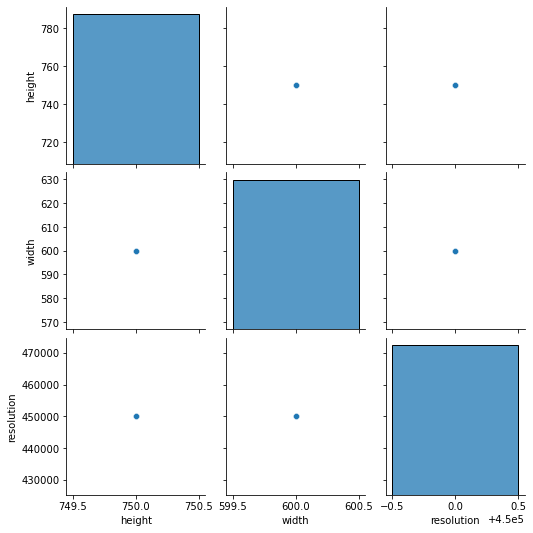

In [63]:
import seaborn as sns
sns.pairplot(df)

***Description of images:***

**Portrait photographs**: 
- 120 feature humans
- 5 feature animals
- 34 are professional portraits 
- 6 feature vehicles (cars, bikes, military) 
- 12 pictures from war time 
- 4 feature JFK 

**Still life photography**: 
- 9 have nature backgrounds 


* Vertical: 65 
* Square: 15 
* Landscape: 44 

# Use the code below to process ALL photos and feed them to the model!!!

In [64]:
df = create_dataframe(image_folder)
prep_dataframe(df)

#add padd(image).tolist()
#caused TypeError: unsupported operand type(s) for /: 'list' and 'int'


processing 2 photos for training
dropped  0 photos because they were too large to process
dropped  0 photos because they were too small to process
image converted to LAB
image processed
image converted to LAB
image processed


In [65]:
def mode(): 
    model1 = Sequential([
        #encoder
        Conv2D(128, 2, strides = 2, padding = "same", activation = "relu", input_shape= (img_height, img_width, 1)), #testing shape changes
        Conv2D(256, 2, strides = 2, padding = "same", activation = "relu"), 
        Conv2D(512, 2, strides = 2, padding = "same", activation = "relu"), 

        #decoder
        Conv2D(256, 2, padding = "same", activation = "relu"), 
        UpSampling2D(2),
        Conv2D(128, 2, padding = "same", activation = "relu"), 
        UpSampling2D(2), 
        Conv2D(2, 2, padding = "same", activation = "tanh"), 
        UpSampling2D(2),
    ]) #softmax
    model1.compile(optimizer ="adam", loss = "mse", metrics = ["accuracy"])
    return model1

In [66]:
model1 = mode()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 944, 944, 128)     640       
                                                                 
 conv2d_1 (Conv2D)           (None, 472, 472, 256)     131328    
                                                                 
 conv2d_2 (Conv2D)           (None, 236, 236, 512)     524800    
                                                                 
 conv2d_3 (Conv2D)           (None, 236, 236, 256)     524544    
                                                                 
 up_sampling2d (UpSampling2D  (None, 472, 472, 256)    0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 472, 472, 128)     131200    
                                                        

In [67]:
#train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

In [68]:
len(X_train)

2

In [69]:
type(X_train)

list

In [70]:
type(X_train[0])

numpy.ndarray

In [71]:
X_train_debug = X_train[0][0,:,:,:]
Y_train_debug = Y_train[0]*128
Y_train_debug = Y_train_debug[0,:,:,:]
debug_merged = np.dstack((X_train_debug, Y_train_debug))
debug_converted = color.lab2rgb(debug_merged)

C:\Users\midyr\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3116856 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


In [72]:
X_train_debug.shape

(1888, 1888, 1)

In [75]:
X_train_re = X_train_debug.reshape(1, img_height, img_width, 1)
X_train_re.shape

(1, 1888, 1888, 1)

In [76]:
Y_train_re = Y_train_debug.reshape(1, img_height, img_width, 2)
Y_train_re.shape

(1, 1888, 1888, 2)

In [126]:
Y_train_re = Y_train_re/128

In [127]:
print(np.min(Y_train_re[0]), np.max(Y_train_re[0]))

0.0 255.0


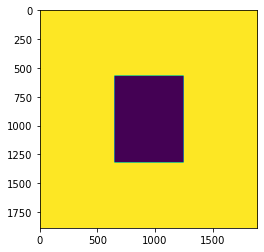

In [128]:
plt.imshow(Y_train_debug[:,:,0])

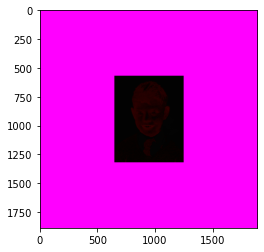

In [130]:
plt.imshow(debug_converted)

In [144]:
epochs = 100
history = model1.fit(X_train_re, Y_train_re, batch_size = batch_size, epochs = epochs, verbose = 2)  # add validation_split = 0.2
#filename = 'finalized_model1_1.sav'
#joblib.dump(history, filename)

Epoch 1/100
1/1 - 4s - loss: 56371.3516 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 2/100
1/1 - 4s - loss: 56371.3711 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 3/100
1/1 - 4s - loss: 56371.3867 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 4/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 5/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 6/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 7/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 8/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 9/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 10/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 11/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 12/100
1/1 - 4s - loss: 56371.3906 - accuracy: 0.9537 - 4s/epoch - 4s/step
Epoch 13/100
1/1 - 4s - loss: 56371.3

In [145]:
#test_path = "C:/Study/Semester2/Machine Learning/ML - Yes Photos/1900s_loose_bw_0036_mom.jpg"
test_path = "C:/Study/Semester2/Machine Learning/smaller2/boy1.jpg"

In [153]:
Color, BW = prep_img(test_path)

image converted to LAB
image processed


In [154]:
#test_data = tf.data.Dataset.from_tensor_slices(BW)
test_predict = model1.predict(BW) #what shape does the prediction takes?

In [155]:
type(test_predict)

numpy.ndarray

In [156]:
test_predict.shape

(1, 1888, 1888, 2)

In [157]:
test_predict = test_predict[0,:,:,:]

In [158]:
test_predict.shape

(1888, 1888, 2)

In [159]:
test_predict = test_predict*128

In [160]:
np.min(test_predict[0])

128.0

In [161]:
np.max(test_predict[0])

128.0

In [162]:
BW = BW[0,:,:,:]

In [163]:
BW.shape

(1888, 1888, 1)

#### merge with d stack

In [164]:
Test_merged = np.dstack((BW, test_predict))

In [165]:
Test_merged.shape

(1888, 1888, 3)

In [166]:
rgb_converted = color.lab2rgb(Test_merged)

C:\Users\midyr\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 32684 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


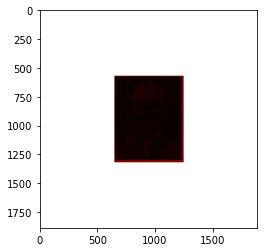

In [167]:
plt.imshow(rgb_converted)

In [168]:

plt.imsave('result.jpg', rgb_converted)

##### a way to merge the prediction

In [169]:
#pastes predicted AB to RGB blank canvas
canvas = np.zeros((1888,1888,3))
canvas[:,:,0] = BW[0][:,:,0]
canvas[:,:,1:] =test_predict[0]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [170]:
#convert AB (in RGB space) to rgb photo
rgb_converted = color.lab2rgb(canvas)

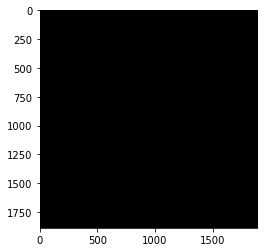

In [171]:
plt.imshow(rgb_converted)

In [172]:
lab_2rgb = cv2.cvtColor(canvas, cv2.COLOR_RGB2Lab)

error: OpenCV(4.5.5) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x62bfd855::Set<3,-1,-1>,struct cv::impl::A0x62bfd855::Set<0,5,-1>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [173]:
lab_to = 

SyntaxError: invalid syntax (<ipython-input-173-7cfd94be212e>, line 1)

In [174]:
lab_merge.shape

NameError: name 'lab_merge' is not defined

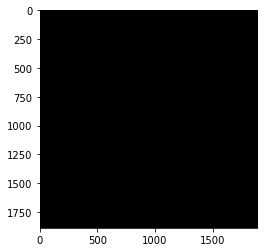

In [175]:
plt.imshow(canvas)

In [176]:
#Test input array

In [177]:
img_path1 = 'Color, BW = prep_img(test_path)'
Y01, X01 = prep_img(img_path1)

AxisError: axis -1 is out of bounds for array of dimension 0

In [178]:
type(X01[0])

numpy.ndarray

TypeError: Invalid shape (1, 1888, 1888, 1) for image data

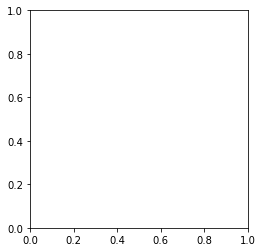

In [179]:
#show AB channel of the image
plt.imshow(X01) #X01[0,:,:,0]

In [180]:
df_X01 = pd.DataFrame(X01[0,:,:,0])

In [181]:
df_Y01 = pd.DataFrame(Y01[0,:,:,0])

In [182]:
df_Y01.describe()

,0,1,2,3,4,5,6,7,8,9,...,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887
count,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,...,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0,1888.0
mean,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
25%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
50%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
75%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
max,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
